# load numerical model (Anne M) and inspect

In [2]:
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

import xgcm

# cognac data and tools
#import cognac.insitu as iu
#import pynsitu as pin

----

## load data

To be done on datarmor.
Copy extracted netcdf file back on laptop.


**I don't know what MBATHY stands for**


In [97]:
root_dir = "/home/datawork-lops-osi/equinox/das"

grid_nc = os.path.join(root_dir, "gridT.nc")
grid = xr.open_dataset(grid_nc)

grid = grid.rename(**{"X200_299": "x", "Y110_179": "y", "Z":"depth",
                      "MBATHY": "bottom", "NAV_LON": "lon", "NAV_LAT": "lat",
                     } )
grid = (grid
        .set_index(depth="NAV_LEV")
        .set_coords(["lon", "lat"])
        .squeeze()
       )
grid = grid.assign_coords(h=grid.depth.isel(depth=grid.bottom).drop("depth"))

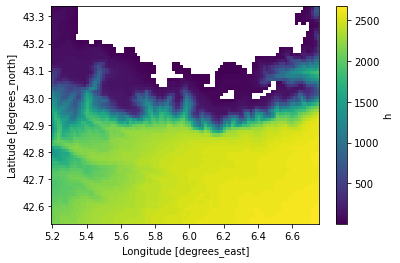

In [98]:
grid.h.where(grid.h>1).plot(x="lon", y="lat")

In [99]:
nc_files = sorted(glob(os.path.join(root_dir, "Temp_*.nc")))

nc = nc_files[0]
ds = xr.open_dataset(nc)
ds = ds.rename(**{"X200_299": "x", "Y110_179": "y", "DEPTHT":"depth",
                  "TIME_COUNTER": "time", 
                  "DEPTHT_bnds": "z_bounds",
                  "VOTEMPER": "temperature",
                 } 
              )
ds = ds.assign_coords(**grid)

ds

<xarray.Dataset>
Dimensions:      (x: 100, y: 70, depth: 130, bnds: 2, time: 72)
Coordinates:
  * x            (x) float64 200.0 201.0 202.0 203.0 ... 296.0 297.0 298.0 299.0
  * y            (y) float64 110.0 111.0 112.0 113.0 ... 176.0 177.0 178.0 179.0
  * depth        (depth) float32 0.5 1.5 2.5 ... 2.768e+03 2.801e+03 2.833e+03
  * time         (time) datetime64[ns] 2019-07-14T00:30:00 ... 2019-07-16T23:...
    lon          (y, x) float32 ...
    lat          (y, x) float32 ...
    h            (y, x) float64 2.116e+03 2.148e+03 2.148e+03 ... 712.9 712.9
    bottom       (y, x) int16 107 108 108 109 109 110 110 ... 16 36 43 48 64 64
Dimensions without coordinates: bnds
Data variables:
    z_bounds     (depth, bnds) float32 ...
    temperature  (time, depth, y, x) float32 ...
Attributes:
    history:      FERRET V7.3 (optimized) 27-Jun-22
    Conventions:  CF-1.6

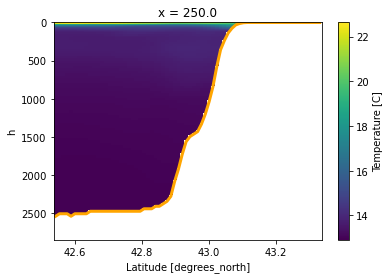

In [103]:
da = ds.temperature.isel(x=50)

fig, ax = plt.subplots(1,1)
da.isel(time=0).plot(x="lat", y="depth", ax=ax)

da.h.plot(x="lat", color="orange", lw=3)

ax.invert_yaxis()

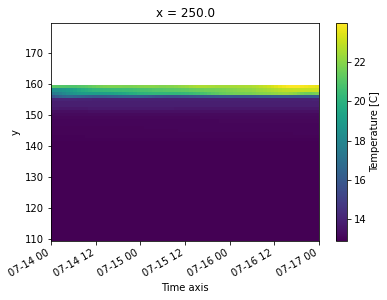

In [112]:
_da = da.isel(depth=da.bottom-1)

_da.plot(x="time")

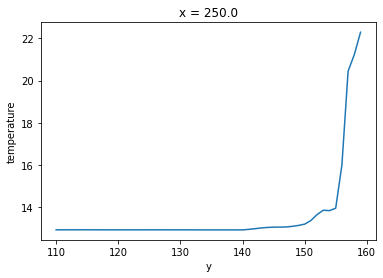

In [114]:
_da.mean("time").plot()

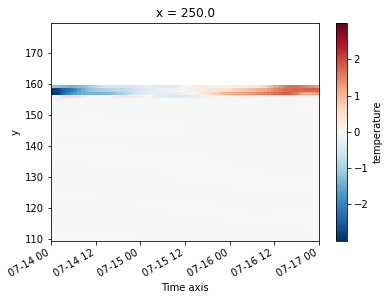

In [113]:
(_da-_da.mean("time")).plot(x="time")

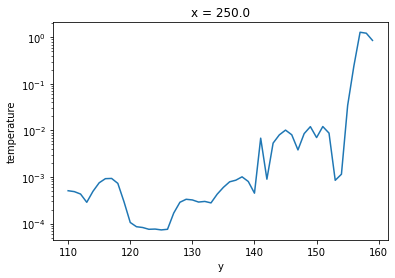

In [117]:
(_da-_da.mean("time")).std("time").plot(yscale="log")

### store data